 # Create figures for the paper

In [1]:
import pandas as pd
from itertools import product
import matplotlib.colors as mcolors
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx as nx

import sys
sys.path.append("/Users/aleix11alcacer/Projects/archetypes")

from archetypes.visualization import heatmap


In [39]:
dataset = "restaurants"

## Original dataset

In [40]:
if dataset == "drugs":
    df = pd.read_csv("datasets/drugs/ChSe-Decagon_monopharmacy.csv")
elif dataset == "restaurants":
    df = pd.read_csv("datasets/restaurants/rating_final.csv")
else:
    import scipy.io as scio
    mat = scio.loadmat('datasets/nips/nips12raw_str602.mat')
    
    df = pd.DataFrame(columns=['paper_id', 'author_id'])
    
    for paper_id, authors_id in enumerate(mat["apapers"]):
        authors_id = authors_id[0][0]
        for author_id in authors_id:
            df_i = pd.DataFrame({"paper_id": f"p{paper_id}", "author_id": f"a{author_id}"}, index=[paper_id])
            df = pd.concat([df, df_i], ignore_index=True)
    
df.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [41]:
bottom_nodes = df.iloc[:, 0].unique()
top_nodes = df.iloc[:, 1].unique()

# generator = np.random.default_rng(0)
# bottom_nodes = generator.choice(bottom_nodes, 500, replace=False)
# top_nodes = generator.choice(top_nodes, 500, replace=False)

B = nx.Graph()
B.add_nodes_from(bottom_nodes, bipartite=0)
B.add_nodes_from(top_nodes, bipartite=1)

B.add_edges_from([(row.iloc[0], row.iloc[1]) for idx, row in df.iterrows()])

a_np = bipartite.biadjacency_matrix(B, bottom_nodes, top_nodes).todense().astype(np.float32)

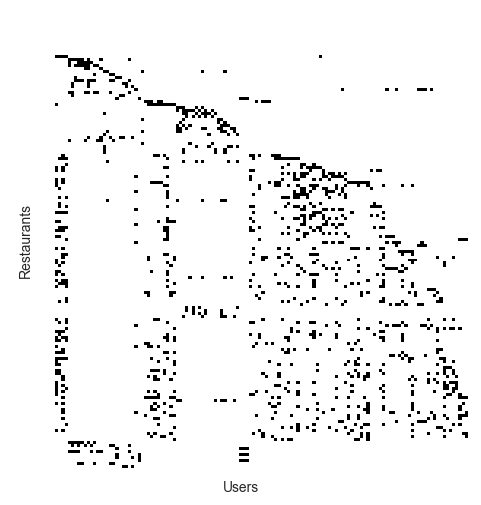

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

heatmap(a_np, ax=ax)

ax.set_aspect("auto")

if dataset == "drugs":
    xlabel = "Side effects"
    ylabel = "Drugs"
elif dataset == "restaurants":
    xlabel = "Users"
    ylabel = "Restaurants"
else:
    xlabel = "Authors"
    ylabel = "Papers"
    

ax.annotate(xlabel, xy=(0.5, -0.05), xycoords="axes fraction", ha="center", va="bottom")
ax.annotate(ylabel, xy=(0.05, 0.5), xycoords="axes fraction", ha="right", va="center", rotation=90)

plt.show()

In [43]:
# fig.savefig(f"figures/{dataset}_data.pdf", bbox_inches="tight")

## Boxplots with ROC-AUC results

In [2]:
results = pd.read_csv(f"rest_results.csv")

results.head()

,Unnamed: 0,auc,prauc,model,assignment,k,iteration
0,0,0.848743,0.053680,BiAA,soft,2,0
1,1,0.805068,0.015117,BiAA,hard,2,0
2,2,0.817052,0.016196,BiAA,soft-hard,2,0
3,3,0.850268,0.042212,SBM,soft,2,0
4,4,0.674720,0.010322,SBM,hard,2,0


In [12]:
def boxplot(results, ymax, ax=None, order=None):
    def create_palette(saturation, value, n_colors, int_colors=3):
        hue = np.linspace(0, 1, n_colors, endpoint=False)
        hue = np.hstack([hue[i::int_colors] for i in range(int_colors)])
        saturation = np.full(n_colors, saturation)
        value = np.full(n_colors, value)
        # convert to RGB
        c = mpl.colors.hsv_to_rgb(np.vstack([hue, saturation, value]).T)
        # Create palette
        palette = mpl.colors.ListedColormap(c)
        return palette
    
    def grouped(iterable, n):
        return zip(*[iter(iterable)]*n)
    
    def iterate_bplot(bplots): 
        for i, bplot in enumerate(bplots):
            boxes = bplot["boxes"]
            fliers = bplot["fliers"]
            medians = bplot["medians"]
            whiskers = grouped(bplot["whiskers"], 2)
            caps = grouped(bplot["caps"], 2)
            yield *boxes, *fliers, *medians, *whiskers, *caps
    
    if ax is None:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    bplots = []
    for i, (assignment, model) in enumerate(product(order["assignment"], order["model"])):
        results_i = results[(results.assignment == assignment) & (results.model == model)]
        bplot_i = ax.boxplot(results_i.auc, positions=[i], widths=0.75, patch_artist=True)
        bplots.append(bplot_i)
    
    xticklabels = [model for (assignment, model) in product(order["assignment"], order["model"])]
    ax.set_xticks(range(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    
    ax.set_ylabel("ROC-AUC")
    
    # ax.set_xlabel("Model")
    
    # get matplotlib cmap
    import matplotlib as mpl
    
    cmap = create_palette(0.5, 0.9, len(order["model"]), int_colors=1)
    colors = cmap(range(len(order["model"])))

    # repeat colors
    colors = np.vstack([colors, colors])
    alpha1 = 0.6
    alpha2 = 0.1
    
    for (assignment, model), (box, flier, median, whiskers, caps), c in zip(product(order["assignment"], order["model"]), iterate_bplot(bplots), colors):
        
        # convert c to rgb
        c = np.array(mcolors.to_rgb(c))
        c1 = alpha1 * c + (1 - alpha1) * np.array([1, 1, 1])
        c2 = alpha2 * c + (1 - alpha2) * np.array([1, 1, 1])
        
        c2 = tuple(c1) if assignment == "hard" else tuple(c2)
    
        box.set_edgecolor(c)
        box.set_facecolor(c2)
        
        flier.set_markeredgecolor(c)
        flier.set_markerfacecolor(c2)
        
        median.set_color(c)
        
        for whisker in whiskers:
            whisker.set_color(c)
            
        for cap in caps:
            cap.set_color(c)
            
    # ax.set_ylim(bottom=.5, top=1)
    
    # add to legend two rectangles
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    c = np.array(mcolors.to_rgb("gray"))
    c1 = alpha1 * c + (1 - alpha1) * np.array([1, 1, 1])
    c2 = alpha2 * c + (1 - alpha2) * np.array([1, 1, 1])
    
    legend_elements = [
        Patch(facecolor=c2, edgecolor=c, label="soft"),
        Patch(facecolor=c1, edgecolor=c, label="hard"),
        [Line2D([0], [0], color=c, label=model)
        for model, c in zip(order["model"], colors)]
    ]
    
    # ax.legend(handles=[*legend_elements[0:2], *legend_elements[2]], loc="lower right")
    
    # hide vertical grid lines
    ax.grid(axis="x", linestyle="", linewidth=0.5)
    
    # add vertical line
    ax.axvline(x=len(order["model"]) - .5, linestyle=(0, (10, 20)), color="gray", linewidth=0.5)
    
    # get y limits

    ax.set_ylim(bottom=0.45)
    ax.set_ylim(top=ymax + 0.05 * (ymax - 0.45))
    
    # annotate hard soft
    for i, assignment in enumerate(order["assignment"]):
        ax.annotate(f"{assignment} assignment",
                    xy=((i + 0.5) * len(order["model"]) - 0.5, 0.47), 
                    ha="center", 
                    va="center", 
                    color="k")

    return ax

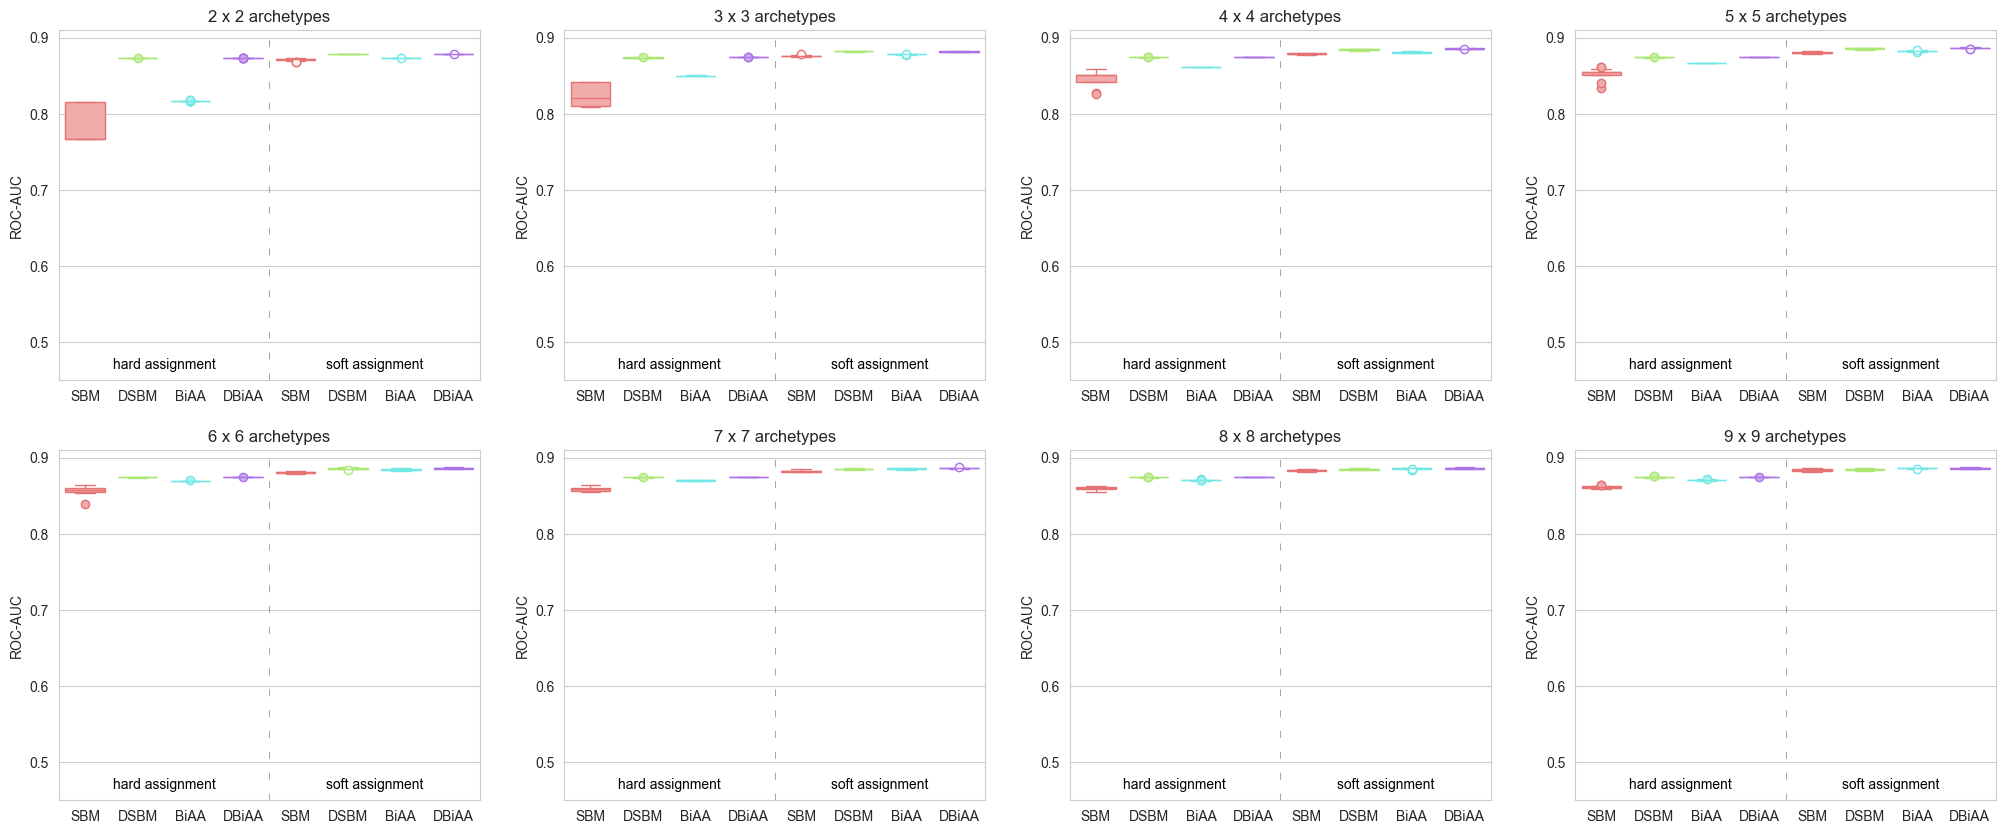

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(25, 10))

order = {"assignment": ["hard", "soft"], "model": ["SBM", "DSBM", "BiAA", "DBiAA"]}

max = results.auc.max()
for i, ax_i in enumerate(ax.flatten()):
    k = i + 2
    boxplot(results[results.k == k], ax=ax_i, order=order, ymax = max)
    ax_i.set_title(f"{k} x {k} archetypes")

plt.show()

In [6]:
# fig.savefig(f"figures/{dataset}_boxplot.pdf", bbox_inches="tight")